# Trading News and Corporate Actions with BERT

<a href="" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Algo-trading on corporate actions by leveraging NLP. A replicationa and enhancement of the paper: *Trade the Event: Corporate Events Detection for News-Based Event-Driven Trading (Zhou et al., Findings 2021)*.

We will perform the following steps:
1. Domain adaptation for financial articles by finetuning a BERT model with Masked Language Model (MLM) training on financial news and encyclopedia data. *Zhou et al.* utilized human annotators to label news articles with an event.
1. Bi-Level Event Detection: At Token-Level we detect events using a sequence labeling approach. At the higher Article-Level we will augment the corpus with 'CLS' token embedding which contains the the aggregate of all the article's embeddings, and concatenate it with the lower level tokens.
1. Recognize security Ticker, using string matching algorithm to recognize tickers within articles.
1. Create trading signals on the identified tickers.

```bibtex
@inproceedings{zhou-etal-2021-trade,
    title = "Trade the Event: Corporate Events Detection for News-Based Event-Driven Trading",
    author = "Zhou, Zhihan  and
      Ma, Liqian  and
      Liu, Han",
    editor = "Zong, Chengqing  and
      Xia, Fei  and
      Li, Wenjie  and
      Navigli, Roberto",
    booktitle = "Findings of the Association for Computational Linguistics: ACL-IJCNLP 2021",
    month = aug,
    year = "2021",
    address = "Online",
    publisher = "Association for Computational Linguistics",
    url = "https://aclanthology.org/2021.findings-acl.186",
    doi = "10.18653/v1/2021.findings-acl.186",
    pages = "2114--2124",
}
```

# Notebook Environment

For a unified research environment, enable the flags below:

In [1]:
UPGRADE_PY = False
INSTALL_DEPS = False
if INSTALL_DEPS:
  # %pip install -q tensorboard==2.15.2
  # %pip install -q tensorflow[and-cuda]==2.15.1
  # %pip install -q tensorflow==2.15.0
  # %pip install -q tensorflow-io-gcs-filesystem==0.36.0
  # %pip install -q tensorflow-text==2.15.0
  # %pip install -q tf_keras==2.15.1
  # %pip install -q tokenizers==0.15.2
  # %pip install -q torch==2.2.0+cpu
  # %pip install -q torch-xla==2.2.0+libtpu
  # %pip install -q torchdata==0.7.1
  %pip install -q transformers==4.38.2

if UPGRADE_PY:
  !mamba create -n py311 -y
  !source /opt/conda/bin/activate py312 && mamba install python=3.11 jupyter mamba -y

  !sudo rm /opt/conda/bin/python3
  !sudo ln -sf /opt/conda/envs/py312/bin/python3 /opt/conda/bin/python3
  !sudo rm /opt/conda/bin/python3.10
  !sudo ln -sf /opt/conda/envs/py312/bin/python3 /opt/conda/bin/python3.10
  !sudo rm /opt/conda/bin/python
  !sudo ln -sf /opt/conda/envs/py312/bin/python3 /opt/conda/bin/python

!python --version

Python 3.10.14


In [2]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

# Transformers cannot use keras3
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_USE_LEGACY_KERAS'] = '1'
IN_KAGGLE = IN_COLAB = False
!export CUDA_LAUNCH_BLOCKING=1
!export XLA_FLAGS=--xla_cpu_verbose=0

MODEL_PATH = "google-bert/bert-base-cased"
MODEL_PATH_TOKENIZER = "google-bert/bert-base-cased"
try:
  # https://www.tensorflow.org/install/pip#windows-wsl2
  import google.colab
  from google.colab import drive
  drive.mount('/content/drive')
  DATA_PATH = "/content/drive/MyDrive/EDT dataset"
  DATA_PATH = "/content/drive/MyDrive/investopediaBERT"
  IN_COLAB = True
  print('Colab!')
except:
  IN_COLAB = False
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ and not IN_COLAB:
    print('Running in Kaggle...')
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    DATA_PATH = "/kaggle/input/uscorpactionnews"
    MODEL_PATH = "/kaggle/input/bert-base-cased-fine-tuned-on-investopedia/tensorflow2/investopedia/1"
    IN_KAGGLE = True
    print('Kaggle!')
elif not IN_COLAB and not IN_KAGGLE:
    IN_KAGGLE = False
    DATA_PATH = "./data/"
    print('Normal!')
    MODEL_PATH = "./models"


Running in Kaggle...
/kaggle/input/uscorpactionnews/Event_detection/train.txt
/kaggle/input/uscorpactionnews/Event_detection/dev.txt
/kaggle/input/uscorpactionnews/Trading_benchmark/evaluate_news.json
/kaggle/input/uscorpactionnews/Domain_adapation/train.txt
/kaggle/input/uscorpactionnews/Domain_adapation/dev.txt
/kaggle/input/bert-base-cased-fine-tuned-on-investopedia/tensorflow2/investopedia/1/config.json
/kaggle/input/bert-base-cased-fine-tuned-on-investopedia/tensorflow2/investopedia/1/tf_model.h5
Kaggle!


# Accelerators Configuration

If you have a GPU, TPU or in one of the collaborative notebooks. Configure your setup below:

In [3]:
import numpy as np
import pandas as pd

from pathlib import Path
import re
import pickle
from copy import deepcopy

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import mixed_precision

print(f'Tensorflow version: [{tf.__version__}]')

tf.get_logger().setLevel('INFO')

#tf.config.set_soft_device_placement(True)
#tf.config.experimental.enable_op_determinism()
#tf.random.set_seed(1)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
  # Not an exception, just no TPUs available, GPU is fallback
  # https://www.tensorflow.org/guide/mixed_precision
  print(e)
  policy = mixed_precision.Policy('mixed_float16')
  mixed_precision.set_global_policy(policy)
  gpus = tf.config.experimental.list_physical_devices('GPU')
  if len(gpus) > 0:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12288)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        strategy = tf.distribute.MirroredStrategy()

        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
    finally:
        print("Running on", len(tf.config.list_physical_devices('GPU')), "GPU(s)")
  else:
    # CPU is final fallback
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

def is_tpu_strategy(strategy):
    return isinstance(strategy, tf.distribute.TPUStrategy)

print("Number of accelerators:", strategy.num_replicas_in_sync)
os.getcwd()

Tensorflow version: [2.15.0]
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2024-04-30 08:46:00.469514: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:46:00.469621: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:46:00.469703: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:46:00.469772: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:46:00.469839: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:46:00.470037: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:46:00.470183: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

'/kaggle/working'

# Tokens, Sequences, and NER

Our corpus will be processed and labelled to 11 types of corporate events:
1. Acquisition(A)
1. Clinical Trial(CT)
1. Regular Dividend(RD)
1. Dividend Cut(DC)
1. Dividend Increase(DI)
1. Guidance Increase(GI)
1. New Contract(NC)
1. Reverse Stock Split(RSS)
1. Special Dividend(SD)
1. Stock Repurchase(SR)
1. Stock Split(SS).
1. No event (O)

Articles are structured as follows:

```json
'title': 'Title',
'text': 'Text Body',
'pub_time': 'Published datetime',
'labels': {
    'ticker': 'Security symbol',
    'start_time': 'First trade after article published',
    'start_price_open': 'The "Open" price at start_time',
    'start_price_close': 'The "Close" price at start_time',
    'end_price_nday': 'The "Close" price at the last minute of the following 1-3 trading day. If early than 4pm ET its the same day. Otherwise, it refers to the next trading day.',
    'end_time_1-3day': 'The time corresponds to end_price_1day',
    'highest_price_nday': 'The highest price in the following 1-3 trading',
    'highest_time_nday': 'The time corresponds to highest_price_1-3day',
    'lowest_price_nday': 'The lowest price in the following 1-3 trading day',
    'lowest_time_nday': 'The time corresponds to lowest_price_1-3day',
}
```

In [4]:
NUM_LABELS = 12 # See Labels description above.
SPECIAL_TOKEN = 'CLS' # Use for classification and hidden state placeholder.
UNK_ID = -100 # Unknown token, ignored by loss
UNK = 'UNK'
OTHER_ID = 11
OTHER = 'O'

### Tokenizing News Text

The text body is tokenized, a simple example is shown below, including how the '[CLS]' (classification problem token) token is leveraged. BERT's transformer inputs expect of shape [batch_size, seq_length] the following inputs:
- "input_ids": token ids of the input sequences.
- "attention_mask": has value 1 at the position of all input tokens present before padding and value 0 for the padding tokens.
- "token_type_ids": the index of the input that created the input token. The first input segment (index 0) includes the start-of-sequence token and its end-of-segment token. The second segment (index 1, if present) includes its end-of-segment token. Padding tokens get index 0.

Transformers use self-attention mechanisms represent interactions amongst tokens and their contextual information in the input sequence as a weighted-sum. With this mechanism higher layers of the network will aggregate information from all other tokens in the sequence, in our case '[CLS]' will have such information.

Since we are passing the tokens as a batch, we need to give the tokenizer a maximum length on which to either PAD or TRUNCATE.

In [5]:
from transformers import BertTokenizerFast, TFBertModel, BertConfig

# https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#berttokenizerfast
tokenizer = BertTokenizerFast.from_pretrained(MODEL_PATH_TOKENIZER)
model = TFBertModel.from_pretrained(MODEL_PATH)

text = ["When taken as a whole, the evidence suggests Cramer recommends “hot” stocks", "lending credence to the Hot Hand Fallacy in this context."]

tokenized_sequence = tokenizer.tokenize(text)
print(tokenized_sequence)

Some layers from the model checkpoint at /kaggle/input/bert-base-cased-fine-tuned-on-investopedia/tensorflow2/investopedia/1 were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at /kaggle/input/bert-base-cased-fine-tuned-on-investopedia/tensorflow2/investopedia/1 and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['When', 'taken', 'as', 'a', 'whole', ',', 'the', 'evidence', 'suggests', 'C', '##ram', '##er', 'recommend', '##s', '“', 'hot', '”', 'stocks', 'lending', 'c', '##red', '##ence', 'to', 'the', 'Hot', 'Hand', 'Fall', '##acy', 'in', 'this', 'context', '.']


Note how words that weren't in the original model's vocabulary get split using '##', e.g. being *Cramer*'s name.

Running the full tokenizer will get the token IDs, their position (type ID) and the attention mask for BERT:

In [6]:
MAX_LEN = 256 # Default 256, MAX 512
sample_inputs = inputs = tokenizer.encode_plus(
    text,
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    max_length=MAX_LEN,  # Maximum length for padding/truncation, adjust as needed
    padding='max_length',
    return_tensors='tf',
    truncation=True
)
sample_inputs

{'input_ids': <tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101,  1332,  1678,  1112,   170,  2006,   117,  1103,  2554,
         5401,   140,  4515,  1200, 18029,  1116,   789,  2633,   790,
        17901,   102, 21363,   172,  4359,  7008,  1106,  1103,  4126,
         9918,  6760, 15347,  1107,  1142,  5618,   119,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

Below is a textual representation of what the model will see, [CLS] showing the start of the clasification sequence, [SEP] to seperate sequences and [PAD]  to make the word embeddings the same size for batched predictions.

In [7]:
tokenizer.decode(sample_inputs["input_ids"].numpy()[0])

'[CLS] When taken as a whole, the evidence suggests Cramer recommends “ hot ” stocks [SEP] lending credence to the Hot Hand Fallacy in this context. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

The padding is signalled to be ignored by the model through the attention mask:

In [8]:
sample_inputs["attention_mask"].shape

TensorShape([1, 256])

In [9]:
sample_inputs["attention_mask"]

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>

Since we are passing sequences, the model will need to know where one starts and another ends. This is signalled by sequence IDs.

Below we see that the first sequence is `0`, and the next is `1`, these are relevent in sequence classification, which we will be doing in this article:

In [10]:
sample_inputs['token_type_ids']

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>

If we run this from an out-of-the-box model forward pass, we get a sequence of tokens, though nothing is being predicted for now as there are no dense layers or a classification head yet - we only get the batched sequence as outputted by the last activation layer of the BERT model

The line `embedding = hidden_state[:, 0, :]` extracts the embeddings corresponding to the [CLS] token, which is often used as a representation of the entire sequence for classification tasks.

In [11]:
outputs = model(sample_inputs['input_ids'])
hidden_state = outputs.last_hidden_state
embedding = hidden_state[:, 0, :]


# Get the hidden state with all info.

## Dataset

The paper authors provided a labelled dataset which we will process and prepare for the BERT inputs.

In our classification, we will hit some unknown tokens. The authors use ID -100 to denote this, we will use the pretrained tokenizer's ID:

In [12]:
def read_wnut(file_path):
    file_path = Path(file_path)

    raw_text = file_path.read_text().strip()
    raw_docs = re.split(r'\n\t?\n', raw_text)
    token_docs = []
    tag_docs = []
    for doc in raw_docs:
        tokens = []
        tags = []
        for line in doc.split('\n'):
            token, tag = line.split('\t')
            tokens.append(token)
            tags.append(tag)
        token_docs.append(tokens)
        tag_docs.append(tags)

    return token_docs, tag_docs

train_ner_texts, train_ner_tags = read_wnut(os.path.join(DATA_PATH, 'Event_detection/train.txt'))
test_ner_texts, test_ner_tags = read_wnut(os.path.join(DATA_PATH, 'Event_detection/dev.txt'))

event_index = 0
for event_index, tags in enumerate(train_ner_tags):
    if any(tag != 'O' for tag in tags):
        break
print(f"event found at index: {event_index}")
print(*train_ner_texts[event_index])
print(*train_ner_tags[event_index])

event found at index: 5963
FDA Approves EYLEA ( aflibercept ) Injection sBLA in Wet Age-related Macular Degeneration TARRYTOWN , N.Y. , Aug . 17 , 2018 / / Regeneron Pharmaceuticals , Inc . ( NASDAQ: REGN ) today announced that the U.S . Food and Drug Administration ( FDA ) has approved a supplemental Biologics License Application ( sBLA ) for EYLEA ( aflibercept ) Injection in patients with wet age-related macular degeneration ( wet AMD ) . The sBLA was based on second-year data from the Phase 3 VIEW 1 and 2 trials in which patients with wet AMD were treated with a modified 12-week dosing schedule ( doses given at least every 12 weeks , and additional doses as needed ) . These data are now included in the updated EYLEA label . "We are pleased that the FDA has approved an updated label for EYLEA," said George D . Yancopoulos , M.D. , Ph.D. , President and Chief Scientific Officer of Regeneron . "Providing information to retinal physicians about the visual outcomes with a modified 12-we

In [13]:
from transformers import BertTokenizerFast

def encode_tags(tags, encodings, tag2id, unk=UNK_ID):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    for doc_labels, doc_offset in tqdm(zip(labels, encodings.offset_mapping), desc="encode_tags"):
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset), dtype=int) * unk
        arr_offset = np.array(doc_offset)

        # set labels whose first offset position is 0 and the second is not 0
        max_len = len(doc_enc_labels[(arr_offset[:, 0] == 0) & (arr_offset[:, 1] != 0)])
        doc_enc_labels[(arr_offset[:, 0] == 0) & (arr_offset[:, 1] != 0)] = doc_labels[:max_len]
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels

def encode_sequence_labels(ner_tags, tag2id, num_labels=MAX_LEN):
    seq_labels = []

    for tag in ner_tags:
        tag_set = set(tag)
        current_label = np.zeros([num_labels])
        if len(tag_set) == 1:
            current_label[tag2id[OTHER]] = 1
        else:
            # here is a bias, if a seq has another event, drop all others?
            # This is 'OHE' label
            tag_set.remove(OTHER)
            for tag in tag_set:
                current_label[tag2id[tag]] = 1
        seq_labels.append(list(current_label))

    return seq_labels

def load_and_cache_dataset(train_ner_texts, train_ner_tags,
                           test_ner_texts, test_ner_tags,
                           bert_model_tok=MODEL_PATH_TOKENIZER,
                           max_len=MAX_LEN,
                           num_labels=NUM_LABELS):
    tokenizer = BertTokenizerFast.from_pretrained(bert_model_tok)

    tags = deepcopy(train_ner_tags)
    tags.extend(test_ner_tags)
    unique_tags = list(set(tag for doc in tags for tag in doc))
    tag2id = {tag: id for id, tag in enumerate(sorted(unique_tags))}
    id2tag = {id: tag for tag, id in tag2id.items()}

    # Tokenize and encode labels for training and testing data
    train_encodings = tokenizer(train_ner_texts,
                                is_split_into_words=True,
                                return_offsets_mapping=True,
                                padding='max_length',
                                truncation=True,
                                max_length=max_len)
    train_ner_labels = encode_tags(train_ner_tags, train_encodings, tag2id, UNK_ID)
    train_seq_labels = encode_sequence_labels(train_ner_tags, tag2id, num_labels=num_labels)

    test_encodings = tokenizer(test_ner_texts,
                               is_split_into_words=True,
                               return_offsets_mapping=True,
                               padding='max_length',
                               truncation=True,
                               max_length=max_len)
    test_ner_labels = encode_tags(test_ner_tags, test_encodings, tag2id, UNK_ID)
    test_seq_labels = encode_sequence_labels(test_ner_tags, tag2id, num_labels=num_labels)

    # offset_mapping no longer needed
    train_encodings.pop("offset_mapping")
    test_encodings.pop("offset_mapping")

    return (train_encodings, train_ner_labels,
            test_encodings, test_ner_labels,
            train_seq_labels, test_seq_labels,
            tag2id, id2tag)

(train_encodings, train_ner_labels,
 test_encodings, test_ner_labels,
 train_seq_labels, test_seq_labels,
 tag2id, id2tag) = load_and_cache_dataset(train_ner_texts,
                                            train_ner_tags,
                                            test_ner_texts,
                                            test_ner_tags)
input_ids = np.array(test_encodings['input_ids'])
attention_mask = np.array(test_encodings['attention_mask'])
token_type_ids = np.array(test_encodings['token_type_ids']) if 'token_type_ids' in train_encodings else None
ner = np.array(test_ner_labels)
seq_label = np.array(test_seq_labels)
print("input_ids shape:", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)
if token_type_ids is not None:
    print("token_type_ids shape:", token_type_ids.shape)

print("ner_labels shape:", ner.shape)
print("train_seq_labels shape:", seq_label.shape)

encode_tags: 7770it [00:01, 7607.60it/s]
encode_tags: 1948it [00:00, 7499.74it/s]


input_ids shape: (1948, 256)
attention_mask shape: (1948, 256)
token_type_ids shape: (1948, 256)
ner_labels shape: (1948, 256)
train_seq_labels shape: (1948, 12)


Let's check our tokenized dataset, we have the input ids being the word encodings and the entities labels:

In [14]:
id2tag

{0: 'I-A',
 1: 'I-CT',
 2: 'I-DC',
 3: 'I-DI',
 4: 'I-GC',
 5: 'I-NC',
 6: 'I-RD',
 7: 'I-RSS',
 8: 'I-SD',
 9: 'I-SR',
 10: 'I-SS',
 11: 'O'}

In [15]:
print(input_ids[:10].shape)
input_ids[:10]

(10, 256)


array([[  101, 13359, 16253, ..., 20315,   119,   102],
       [  101,  5386,  4522, ...,  3113,  4604,   102],
       [  101,   160,   119, ..., 27719,  1162,   102],
       ...,
       [  101, 24664, 18056, ...,  6178,  1104,   102],
       [  101, 10983,  1391, ...,   189,  4043,   102],
       [  101,   156,  5730, ...,  5777,   118,   102]])

In [16]:
print(ner[:10].shape)
ner[:10]

(10, 256)


array([[-100,    8, -100, ...,   11,   11, -100],
       [-100,   11,   11, ..., -100,   11, -100],
       [-100,    8,    8, ..., -100, -100, -100],
       ...,
       [-100,    0, -100, ...,   11,   11, -100],
       [-100,   10,   10, ..., -100, -100, -100],
       [-100,    0, -100, ...,   11, -100, -100]])

In [17]:
assert not np.isnan(input_ids).any()

## Inside, Outside, Beginning Tags

The IOB or BIO format is used in tagging chunks of words in NLP.

- I before a tag indicates that the tag is inside a chunk.
- O tag indicates that a token belongs to no chunk.
- B before a tag indicates that the tag is the beginning of a chunk that immediately follows another chunk without O tags between them.

## Imbalanced Dataset

Before you continue, looking at the tag frequencies - we see that our data set is imbalanced towards the `O` and `UNK` tags.



In [18]:
from sklearn.utils.class_weight import compute_class_weight

unique, counts = np.unique(ner, return_counts=True)

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
weights = compute_class_weight(class_weight="balanced", classes=np.unique(ner), y=ner.flatten())
weights_dict = {i: weights[i] for i in range(len(weights))}

df_tags = pd.DataFrame({'Tag ID': unique, 'Tag': (id2tag[id] if id in id2tag else UNK for id in unique),'Count': counts})
df_tags['Weight'] = df_tags['Tag ID'].map(lambda i: weights_dict.get(i, 0.))

df_weights = df_tags.sort_values(by='Tag ID', ascending=True)
df_weights.loc[df_weights['Tag ID'] == UNK_ID, 'Weight'] = 0. # Unkown tokens should be ignored totally.
df_weights.loc[df_weights['Tag ID'] == OTHER_ID, 'Weight'] = 0.05 # 'O' is over 75%! Need to reduce it within limits.

class_weights = df_weights[['Tag ID', 'Weight']].set_index('Tag ID').to_dict()['Weight']

df_weights

,Tag ID,Tag,Count,Weight
0,-100,UNK,131438,0.000000
1,0,I-A,1998,0.291853
2,1,I-CT,3349,19.199507
3,2,I-DC,710,11.454349
4,3,I-DI,1764,54.029036
5,4,I-GC,569,21.746381
6,5,I-NC,5094,67.417602
7,6,I-RD,1945,7.530549
8,7,I-RSS,441,19.722681
9,8,I-SD,474,86.985522


Give the class wieghts tot the model.

### Attention is all you Need

Vaswani et. al seminal paper *Attention is All You Need*, made self-attention and transformers mainstream.

Self-attention, calculates the relevance of each word in a sentence to every other word. This is done through queries (Q=XW^Q), keys (K=XW^K), and values (V=XW^V) transformed by a learned weight matrix (W) from the input embeddings (X). The attention score between two words is computed by taking the dot product of their queries and keys, followed by a softmax:

$ \text{A}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $

Where:
- Q represents the queries matrix of current items,
- K represents the keys matrix of items to compare against in the input sequence,
- V represents the values matrix, which are the dot product comparisons between Q and K,
- d_k represents the dimension of the keys and queries,
- A are the Attention wieghts.

In addition, the word embeddings will contain contextual information (dot poduct of A and V), represented as position added to the embedding. This plus the attention wieghts, captures dependencies and relationships.

## BERT Classifier

Built on top of a pretrained BERT (Bidirectional Encoder Representations from Transformers).BERT is an industry tested transformer-based model, pre-trained on a large corpus of text to generate contextual embeddings for input sequences.

We will use a small pre-trained cased base model with 12-layers + 768-hidden, 12-heads , and 110M parameters. This is the base model used in *Zhou et al. (2021)*. Later in the article, we will use larger BERT models that are more resource demanding to fine-tune. Each model has its own preprocesser, as text inputs need to be converted to token IDs.

The architecture can be summarized in 3 componets:
1. Input embeddings, attention masks and ID types for the preTrained BERT model. Bert applies transformer blocks with self-attention (attention captures language structures). The model outputs embedding sequences (last layer from BERT NxH) and a pooled summary derived from the first 'CLS' token(a 1XH vector).
1. The sequence outputs (NxH vector) is passed through dense layers and dropouts for the first NER classification, this maps the high-DIM outputs to logits. Padding of unknown tokens helps the model focus on the tasks.
1. NER logits are flattened and concatenated with the pooled summaries to form a new feature vector (NxH + H). The vector is passed again through dense and dropout layers to classify the event as one of the 11 identified (O is ignored).

The BERT-base architecture stacks 12 encoder-layers, at 100 million tuneable parameters! The BERT-large architecture has 24 encoder-layers and ~350 million parameters.

(1 x BertEmbeddings layer) → (12 x BertLayer layers) → (1 x BertPooler layer over the embedding for ‘[CLS]’ token) → (tanh activation) → (Dropout layer)
Note that the classification head (from the pooler layer)  facilitates training.

# Model Build and Loss

multilabel classification problem. In multilabel classification, each instance (or input) can be assigned multiple labels from a set, rather than just one.

In [19]:
LEARN_RATE=5e-5 # 5e-5
LR_FACTOR=0.1
LR_MINDELTA=1e-4
EPOCHS=100
PATIENCE=10
# TPU see: https://github.com/tensorflow/tensorflow/issues/41635
BATCH_SIZE = (8 * 1 if not is_tpu_strategy(strategy) else 4) * strategy.num_replicas_in_sync # Default 8

In [20]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import AdamW, Adam
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.losses import Loss, SparseCategoricalCrossentropy, CategoricalFocalCrossentropy, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import Metric, SparseCategoricalAccuracy, Precision, Recall, BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, Callback, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from tensorflow.keras.utils import register_keras_serializable

from transformers import TFBertModel, BertConfig

# https://www.tensorflow.org/api_docs/python/tf/keras/Metric
@register_keras_serializable(package='Custom', name='MultilabelBinaryAccuracy')
class MultilabelBinaryAccuracy(Metric):
    def __init__(self, name='multilabel_binary_accuracy', labels_len=11, **kwargs):
        super(MultilabelBinaryAccuracy, self).__init__(name=name, **kwargs)
        self.correct_predictions = self.add_weight(name='correct', initializer='zeros')
        self.total_predictions = self.add_weight(name='total', initializer='zeros')
        self.labels_len = labels_len

    def update_state(self, y_true, y_pred, sample_weight=None):
        mask = tf.logical_and(tf.greater_equal(y_true, 0), tf.less(y_true, self.labels_len))
        y_true_masked = tf.where(mask, y_true, tf.zeros_like(y_true))
        y_true_masked = tf.cast(y_true_masked, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
        matches = tf.cast(tf.equal(y_true_masked, y_pred), tf.float32)
        self.correct_predictions.assign_add(tf.reduce_sum(matches))
        self.total_predictions.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def reset_states(self):
        self.correct_predictions.assign(0.)
        self.total_predictions.assign(0.)

    def result(self):
        return (tf.cast(self.correct_predictions, tf.float32) / 
                tf.cast(self.total_predictions, tf.float32))
    
@register_keras_serializable(package='Custom', name='MaskedWeightedMultiClassBCE')
class MaskedWeightedMultiClassBCE(Loss):
    def __init__(self, 
                 from_logits=False,
                 name='masked_weighted_multi_bce',
                 class_weight=None,
                 labels_len=MAX_LEN,
                 null_class=UNK_ID,
                 focal_gamma=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.from_logits = from_logits
        self.null_class = tf.cast(null_class, tf.float32)
        self.class_weight = None
        self.labels_len = labels_len
        if class_weight is not None:
            class_weights_list = [class_weight[i] for i in sorted(class_weight)]
            self.class_weight = tf.convert_to_tensor(class_weights_list, dtype=tf.dtypes.float32)
        self.focal_gamma = focal_gamma
        self.loss_fn = BinaryCrossentropy(from_logits=self.from_logits, 
                                          reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        mask = tf.logical_and(tf.greater_equal(y_true, 0), tf.less(y_true, self.labels_len - 1))
        y_true_masked = tf.where(mask, y_true, tf.zeros_like(y_true))
        y_true_masked = tf.cast(y_true_masked, tf.float32)
        loss = self.loss_fn(y_true_masked, y_pred)
        loss = tf.reduce_mean(loss)
        loss = tf.where(tf.math.is_nan(loss), 0., loss)
        return loss
    
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalFocalCrossentropy
@register_keras_serializable(package='Custom', name='MaskedWeightedSCCE')
class MaskedWeightedSCCE(Loss):
    def __init__(self, 
                 from_logits=False,
                 name='masked_weighted_scce',
                 class_weight=None,
                 labels_len=MAX_LEN,
                 null_class=UNK_ID,
                 focal_gamma=None, 
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.from_logits = from_logits
        self.null_class = tf.cast(null_class, tf.float32)
        self.class_weight = None
        self.labels_len = labels_len
        if class_weight is not None:
            class_weights_list = [class_weight[i] for i in sorted(class_weight)]
            self.class_weight = tf.convert_to_tensor(class_weights_list, dtype=tf.dtypes.float32)
        self.focal_gamma = focal_gamma
        
        # https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
        self.loss_fn = SparseCategoricalCrossentropy(from_logits=self.from_logits, 
                                                reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        mask = tf.logical_and(tf.greater_equal(y_true, 0), tf.less(y_true, self.labels_len - 1))
        y_true_masked = tf.where(mask, y_true, tf.zeros_like(y_true))
        y_true_masked = tf.cast(y_true_masked, tf.float32)
        if tf.executing_eagerly():
            tf.debugging.assert_greater(tf.reduce_sum(tf.cast(mask, tf.int32)),
                                        0, message="All data are masked!")

        

        if self.focal_gamma is not None:
            # inspired by: https://github.com/artemmavrin/focal-loss/blob/master/src/focal_loss/_categorical_focal_loss.py
            loss = self.loss_fn(y_true_masked, y_pred)
            y_pred = tf.clip_by_value(y_pred, clip_value_min=-100., clip_value_max=100.)
            proba = tf.nn.softmax(y_pred)
            y_true_rank = y_true_masked.shape.rank

            p_t = tf.gather(proba, tf.cast(y_true_masked, tf.int32),
                            axis=-1, batch_dims=y_true_rank)
            focal_modulation = tf.cast((1. - tf.clip_by_value(p_t, 0.01, 0.99)) ** self.focal_gamma, tf.float32)
            loss *= focal_modulation
            if self.class_weight is not None:
                loss *= tf.gather(self.class_weight, tf.cast(y_true_masked, tf.int32))
            if tf.executing_eagerly():
                tf.debugging.assert_all_finite(focal_modulation, "Focal contains NaN or Inf")
        else:
          # We remove wieghts from focal loss as we zero the UNK class (ln(0)).
          loss = self.loss_fn(y_true_masked, y_pred, 
                             sample_weight=tf.gather(self.class_weight,
                                                 tf.cast(y_true_masked, tf.int32)) if self.class_weight is not None
                                                 else None)
        loss = tf.cast(loss, tf.float32)
        loss *=  tf.cast(mask, tf.float32)
        # Avoid div by 0.
        sum_mask = tf.reduce_sum(tf.cast(mask, tf.float32))
        if tf.executing_eagerly():
            tf.debugging.assert_positive(sum_mask, message="sum_mask zeroed.")
        loss = (tf.reduce_sum(loss) / sum_mask
                      if sum_mask > 0.
                      else tf.constant(0., dtype=tf.float32))
        if tf.executing_eagerly():
            tf.debugging.assert_positive(loss, message="Loss masked to zero.")

        return loss

The model uses BERT's Last Hidden Layer which is a high-granularity layer with the output embeddings of the BERT model. These are the contextual embeddings for each token in the input sequence. Essentially, for any input sequence, the BERT model processes it through multiple self-attention and feed-forward layers, this is the output from the last layer. If your input sequence consists of N tokens and the BERT model has a hidden size of H, the output tensor from the last hidden layer will have the shape [batch_size, N, H].
This output is typically used for tasks that require token-level predictions, such as named entity recognition (NER), part-of-speech tagging, or any other task where you need to make a decision for each input token independently.

Also used is the Pooled Output which a single vector summarization derived from the output of the last hidden layer corresponding to the special [CLS] token (the first token of every sequence in BERT, used as an aggregate representation for classification tasks). In BERT, this output is further processed through an additional dense layer with a tanh activation function to produce what is called the "pooled output."
The shape of the pooled output is [batch_size, H], representing a fixed-size embedding for the entire input sequence. and is used in sequence-level classification tasks such as sentiment analysis or any other scenario where you need to classify the entire input sequence into categories.

In [21]:
# https://www.tensorflow.org/text/tutorials/bert_glue
def create_model(bert_model,
                 config,
                 num_labels=NUM_LABELS,
                 max_len=MAX_LEN,
                 unk=UNK_ID,
                 class_weight=None,
                 strategy=strategy):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')
    token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name='token_type_ids')

    bert_outputs = bert_model({"input_ids": input_ids,
                                "attention_mask": attention_mask,
                                "token_type_ids": token_type_ids},
                            return_dict=True)
    bert_sequence_output = tf.cast(bert_outputs.last_hidden_state, tf.float32)
    bert_pooled_output = tf.cast(bert_outputs.pooler_output, tf.float32)

    # Zero Logits that are paddings or special characters.
    mask = tf.cast(attention_mask, tf.float32 )
    mask = tf.expand_dims(mask, -1)
    masked_output = bert_sequence_output * mask

    ner_logits = Dropout(config.hidden_dropout_prob, name='Dropout_ner_1')(masked_output)
    ner_logits = Dense(2048, name='Dense_ner_1', kernel_initializer=GlorotUniform())(ner_logits)
    ner_logits = Dropout(config.hidden_dropout_prob, name='Dropout_ner_2')(ner_logits)
    ner_output = Dense(num_labels, name='ner_output', dtype='float32')(ner_logits)

    # combine NER predictions with entire sequence
    # NER shape is [batch_size, sequence_length, num_classes (12)].
    seq_input = tf.reshape(ner_output,
                           [tf.shape(ner_output)[0], tf.shape(ner_output)[1] * tf.shape(ner_output)[2]])
    seq_input = tf.concat([bert_pooled_output, seq_input], axis=1)

    seq_logits = Dropout(config.hidden_dropout_prob, name='Dropout_seq_1')(seq_input)
    seq_logits = Dense(2048, name='Dense_seq_1', kernel_initializer=GlorotUniform())(seq_logits)
    seq_logits = Dropout(config.hidden_dropout_prob, name='Dropout_seq_2')(seq_logits)
    # -1 as we don't classify 'O' Other - An article has 1+ events or None.
    seq_output = Dense(num_labels, name='seq_output', dtype='float32')(seq_logits)

    model = Model(inputs=[input_ids, attention_mask, token_type_ids],
                  outputs=[ner_output, seq_output])

    # https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy
    optimizer = AdamW(learning_rate=LEARN_RATE, clipnorm=1.0)
    if not is_tpu_strategy(strategy):
      # TPUs already use bfloat16
      optimizer = LossScaleOptimizer(optimizer, dynamic=True)
    model.compile(optimizer=optimizer,
            loss={"ner_output": MaskedWeightedSCCE(from_logits=True, class_weight=None),
                  "seq_output": MaskedWeightedMultiClassBCE(from_logits=True)},
            metrics={"ner_output": ['sparse_categorical_accuracy'],
                     "seq_output": [BinaryAccuracy(threshold=0.5)]})
    return model

def get_tf_datasets(train_encodings, test_encodings, buffer_size=10000, batch_size=BATCH_SIZE):
    def create_dataset(encodings, ner_labels, seq_labels):
        input_ids = np.array(encodings['input_ids'])
        attention_mask = np.array(encodings['attention_mask'])
        token_type_ids = np.array(encodings['token_type_ids']) if 'token_type_ids' in train_encodings else None
        ner_labels = np.array(ner_labels)
        seq_labels = np.array(seq_labels)
        return tf.data.Dataset.from_tensor_slices((
            {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'token_type_ids': token_type_ids,
            },
            {
                'seq_output': seq_labels,
                'ner_output': ner_labels,
            },
        ))
    # TODD: revert to train
    train_dataset = create_dataset(train_encodings, train_ner_labels, train_seq_labels)
    train_dataset = (train_dataset.shuffle(buffer_size=buffer_size)
                                    .batch(batch_size)
                                    .cache()
                                    .prefetch(tf.data.experimental.AUTOTUNE))
    test_dataset = create_dataset(test_encodings, test_ner_labels, test_seq_labels)
    test_dataset = (test_dataset.shuffle(buffer_size=buffer_size)
                                .batch(batch_size)
                                .cache()
                                .prefetch(tf.data.experimental.AUTOTUNE))

    return train_dataset, test_dataset

with strategy.scope():
    train_dataset, test_dataset = get_tf_datasets(train_encodings, test_encodings)

    config = BertConfig.from_pretrained(MODEL_PATH)
    config.num_labels = NUM_LABELS
    bert_model = TFBertModel.from_pretrained(MODEL_PATH, config=config)

    model = create_model(bert_model,
                         config,
                         num_labels=len(id2tag), class_weight=class_weights)
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
    tensorboard_callback = TensorBoard(log_dir='./logs',
                                        histogram_freq=2,
                                        embeddings_freq=2)
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    early_stopping = EarlyStopping(mode='min', patience=PATIENCE, start_from_epoch=1)

    #tf.debugging.enable_check_numerics() # - Assert if no Infs or NaNs go through. not for TPU!
    #tf.config.run_functions_eagerly(not is_tpu_strategy(strategy)) # - Easy debugging
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
    history = model.fit(train_dataset,
                        epochs=EPOCHS,
                        callbacks=[tensorboard_callback, early_stopping, TerminateOnNaN()],
                        verbose="auto",
                        validation_data=test_dataset)

I0000 00:00:1714466784.468383   28358 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-04-30 08:46:24.857949: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:46:24.858107: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
Some layers from the model checkpoint at /kaggle/input/bert-base-cased-fine-tuned-on-investopedia/tensorflow2/investopedia/1 were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializin

Epoch 1/100


2024-04-30 08:48:15.825092: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AssignAddVariableOp.
2024-04-30 08:48:19.911973: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:48:19.915217: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:48:19.915347: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:48:19.915464: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:48:19.915623: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:48:19.915728: E external/local_xla/xla/stream_executor/stream_executor_int

  3/243 [..............................] - ETA: 25s - loss: 2.3507 - ner_output_loss: 1.6714 - seq_output_loss: 0.6794 - ner_output_sparse_categorical_accuracy: 0.4054 - seq_output_binary_accuracy: 0.7248  

2024-04-30 08:49:25.477017: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:49:25.477523: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:49:25.478243: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:49:25.478516: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:49:25.478954: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:49:25.574816: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:49:25.575119: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

  5/243 [..............................] - ETA: 24s - loss: 1.6676 - ner_output_loss: 1.1653 - seq_output_loss: 0.5023 - ner_output_sparse_categorical_accuracy: 0.5188 - seq_output_binary_accuracy: 0.8109

2024-04-30 08:49:25.688219: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:49:25.688545: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:49:25.688706: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:49:25.689877: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:49:25.787056: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:49:25.787607: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:49:25.788061: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

  8/243 [..............................] - ETA: 23s - loss: 1.2771 - ner_output_loss: 0.8758 - seq_output_loss: 0.4014 - ner_output_sparse_categorical_accuracy: 0.5862 - seq_output_binary_accuracy: 0.8626

2024-04-30 08:49:25.985787: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-30 08:49:25.986117: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


 12/243 [>.............................] - ETA: 23s - loss: 1.0023 - ner_output_loss: 0.6871 - seq_output_loss: 0.3152 - ner_output_sparse_categorical_accuracy: 0.6280 - seq_output_binary_accuracy: 0.8928

2024-04-30 08:49:26.381014: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


194/243 [======================>.......] - ETA: 4s - loss: 0.2509 - ner_output_loss: 0.1557 - seq_output_loss: 0.0952 - ner_output_sparse_categorical_accuracy: 0.7054 - seq_output_binary_accuracy: 0.9741

2024-04-30 08:49:44.226497: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


226/243 [==========================>...] - ETA: 1s - loss: 0.2307 - ner_output_loss: 0.1439 - seq_output_loss: 0.0868 - ner_output_sparse_categorical_accuracy: 0.7074 - seq_output_binary_accuracy: 0.9765

2024-04-30 08:49:47.360736: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


243/243 [==============================] - ETA: 0s - loss: 0.2228 - ner_output_loss: 0.1379 - seq_output_loss: 0.0850 - ner_output_sparse_categorical_accuracy: 0.7086 - seq_output_binary_accuracy: 0.9772

2024-04-30 08:50:02.814980: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


243/243 [==============================] - 206s 265ms/step - loss: 0.2228 - ner_output_loss: 0.1379 - seq_output_loss: 0.0850 - ner_output_sparse_categorical_accuracy: 0.7086 - seq_output_binary_accuracy: 0.9772 - val_loss: 0.1208 - val_ner_output_loss: 0.0740 - val_seq_output_loss: 0.0468 - val_ner_output_sparse_categorical_accuracy: 0.7209 - val_seq_output_binary_accuracy: 0.9908
Epoch 2/100
  4/243 [..............................] - ETA: 24s - loss: 0.0871 - ner_output_loss: 0.0562 - seq_output_loss: 0.0310 - ner_output_sparse_categorical_accuracy: 0.7180 - seq_output_binary_accuracy: 0.9922

2024-04-30 08:50:30.351628: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


 75/243 [========>.....................] - ETA: 16s - loss: 0.0857 - ner_output_loss: 0.0550 - seq_output_loss: 0.0306 - ner_output_sparse_categorical_accuracy: 0.7226 - seq_output_binary_accuracy: 0.9925

2024-04-30 08:50:37.389733: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


152/243 [=================>............] - ETA: 9s - loss: 0.0802 - ner_output_loss: 0.0505 - seq_output_loss: 0.0298 - ner_output_sparse_categorical_accuracy: 0.7238 - seq_output_binary_accuracy: 0.9927

2024-04-30 08:50:45.079202: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


212/243 [=========================>....] - ETA: 3s - loss: 0.0779 - ner_output_loss: 0.0502 - seq_output_loss: 0.0277 - ner_output_sparse_categorical_accuracy: 0.7238 - seq_output_binary_accuracy: 0.9934

2024-04-30 08:50:50.979377: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


243/243 [==============================] - 27s 110ms/step - loss: 0.0755 - ner_output_loss: 0.0483 - seq_output_loss: 0.0272 - ner_output_sparse_categorical_accuracy: 0.7246 - seq_output_binary_accuracy: 0.9937 - val_loss: 0.0917 - val_ner_output_loss: 0.0562 - val_seq_output_loss: 0.0355 - val_ner_output_sparse_categorical_accuracy: 0.7251 - val_seq_output_binary_accuracy: 0.9939
Epoch 3/100
 28/243 [==>...........................] - ETA: 21s - loss: 0.0702 - ner_output_loss: 0.0458 - seq_output_loss: 0.0244 - ner_output_sparse_categorical_accuracy: 0.7264 - seq_output_binary_accuracy: 0.9945

2024-04-30 08:51:00.059833: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


243/243 [==============================] - 42s 171ms/step - loss: 0.0512 - ner_output_loss: 0.0334 - seq_output_loss: 0.0178 - ner_output_sparse_categorical_accuracy: 0.7278 - seq_output_binary_accuracy: 0.9961 - val_loss: 0.0907 - val_ner_output_loss: 0.0538 - val_seq_output_loss: 0.0369 - val_ner_output_sparse_categorical_accuracy: 0.7260 - val_seq_output_binary_accuracy: 0.9958
Epoch 4/100
243/243 [==============================] - 27s 109ms/step - loss: 0.0377 - ner_output_loss: 0.0273 - seq_output_loss: 0.0104 - ner_output_sparse_categorical_accuracy: 0.7292 - seq_output_binary_accuracy: 0.9978 - val_loss: 0.1011 - val_ner_output_loss: 0.0567 - val_seq_output_loss: 0.0444 - val_ner_output_sparse_categorical_accuracy: 0.7268 - val_seq_output_binary_accuracy: 0.9957
Epoch 5/100
243/243 [==============================] - 79s 328ms/step - loss: 0.0414 - ner_output_loss: 0.0263 - seq_output_loss: 0.0151 - ner_output_sparse_categorical_accuracy: 0.7294 - seq_output_binary_accuracy: 0.99

In [22]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model

MODEL_SAVE_PATH = './models/bert_news'
model.save(MODEL_SAVE_PATH, save_format='tf')
custom_objects = {
    'MaskedWeightedMultiClassBCE': MaskedWeightedMultiClassBCE,
    'MultilabelBinaryAccuracy': MultilabelBinaryAccuracy,
    'MaskedWeightedSCCE': MaskedWeightedSCCE
}

loaded_model = load_model(MODEL_SAVE_PATH, custom_objects=custom_objects)
loaded_model.summary()

INFO:tensorflow:Assets written to: ./models/bert_news/assets


INFO:tensorflow:Assets written to: ./models/bert_news/assets


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                              

In [23]:
import zipfile
def zip_models(directory, output_filename):
    with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(directory):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(directory, '..')))

zip_models('./models', 'models.zip')

## NER Classifier

In [24]:
traindata = train_dataset.unbatch().batch(1).take(1)

y1 = loaded_model.predict(traindata)
print(f"NER labels shape: {y1[0].shape}")
print(f"Sequence labels shape: {y1[1].shape}")

1/1 [==============================] - 2s 2s/step
NER labels shape: (1, 256, 12)
Sequence labels shape: (1, 12)


In [25]:
predicted_classes = np.argmax(y1[0], axis=-1)

print("Logits (NEW):", y1[0])
print("Predicted classes:", predicted_classes)

predicted_events = (y1[1] > 0.5).astype(int)

print("Logits (SEQ):", y1[1])
predicted_event_names = [[id2tag[i] for i, present in enumerate(article) if present == 1] for article in predicted_events]
print(f"Predicted ({len(predicted_event_names[0])}) Event(s) in article: ({', '.join(predicted_event_names[0])})")

Logits (NEW): [[[-2.5628157  -0.6796168   1.1601806  ... -2.194377    3.2289565
   11.682709  ]
  [-4.19658     0.36043453  0.6833084  ... -2.874432    3.3585544
   16.44646   ]
  [-3.7226145   0.23506176  0.8572776  ... -2.4338112   3.305175
   16.326572  ]
  ...
  [-1.395061   -1.2868966   1.0982381  ... -1.4876481   1.1594579
   17.271109  ]
  [-0.8148467  -2.2502987   1.7647433  ... -1.6124476   2.0486073
   15.852144  ]
  [-0.46528217 -0.77401495  0.9354688  ...  0.11452924  3.1765878
   14.719255  ]]]
Predicted classes: [[11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
  11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
  11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
  11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
  11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
  11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
  11 11 11 11 11 11 11 1

In [26]:
inputs, labels = next(iter(traindata))
print(f"NER Labels found: {labels['ner_output']}")
print(f"Article NER sequence: {labels['seq_output']}")

article_events_tags = [
    [id2tag[idx] if event == 1 else None for idx, event in enumerate(label.numpy())] 
    for label in labels['seq_output']
]
article_events_tags = [
    [tag for tag in event_tags if tag is not None] 
    for event_tags in article_events_tags
]
print(f"Article Events: {article_events_tags}")

NER Labels found: [[-100   11 -100 -100   11   11   11 -100 -100 -100   11   11   11 -100
  -100   11 -100   11   11   11   11   11 -100   11   11 -100   11   11
    11   11   11   11   11 -100 -100   11 -100 -100 -100 -100 -100 -100
    11   11   11   11   11 -100 -100 -100 -100   11   11 -100   11 -100
  -100   11   11   11   11   11   11   11   11   11   11   11   11   11
    11 -100 -100   11   11   11 -100   11   11   11   11   11   11 -100
  -100   11 -100   11   11   11   11   11   11   11   11   11 -100 -100
    11 -100   11   11   11   11   11 -100 -100   11 -100   11   11   11
    11   11   11   11   11   11   11   11   11   11   11   11   11 -100
    11   11   11   11 -100 -100   11 -100   11   11   11   11   11   11
    11   11   11   11   11   11   11   11   11   11   11   11   11 -100
  -100   11 -100 -100   11 -100 -100 -100 -100 -100 -100   11   11 -100
  -100   11   11   11   11   11   11   11   11   11   11   11   11   11
    11   11   11   11   11 -100 -100   11   11

Analyze the 2 losses used. TF internally sums these losses for the whole model.

In [27]:
mask = tf.logical_and(tf.greater_equal(labels['ner_output'], 0), tf.less(labels['ner_output'], MAX_LEN))
mask = tf.cast(mask, tf.float32)
losses = tf.keras.losses.sparse_categorical_crossentropy(labels['ner_output'], y1[0], from_logits=True, ignore_class=UNK_ID)
losses *= mask
mean_loss = tf.reduce_sum(losses) / tf.reduce_sum(tf.cast(mask, tf.float32))

print(f"Mask: {mask}")
print(f"Masked Losses: {losses.numpy()}")
print(f"Mean Loss: {mean_loss.numpy()}")

binary_losses = tf.keras.losses.binary_crossentropy(labels['seq_output'] , y1[1], from_logits=True)
mean_binary_loss = tf.reduce_mean(binary_losses)
print(f"Bin Losses: {binary_losses.numpy()}")
print(f"Mean Binary Loss: {mean_binary_loss.numpy()}")

Mask: [[0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.
  1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.
  0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
  0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.
  0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.
  1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0.]]
Masked Losses: [[0.00000000e+00 6.67569793e-06 0.00000000e+00 0.00000000e+00
  6.91411469e-06 5.84123791e-06 6.31807234e-06 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.00677743e-06 5.48361231e-06
 

KeyError: 'seq_output_multilabel_binary_accuracy'

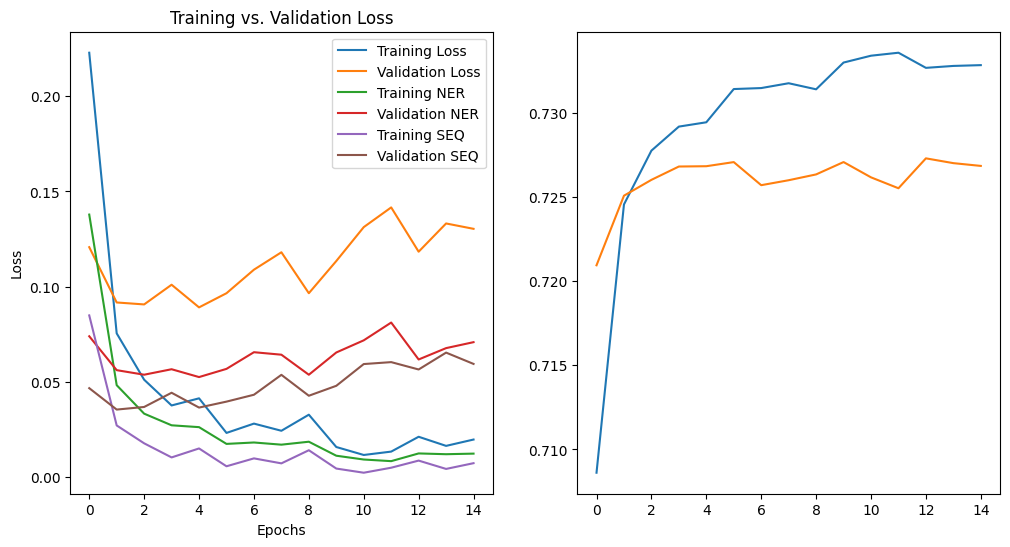

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_classification(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['ner_output_loss'], label='Training NER')
    plt.plot(history.history['val_ner_output_loss'], label='Validation NER')
    plt.plot(history.history['seq_output_loss'], label='Training SEQ')
    plt.plot(history.history['val_seq_output_loss'], label='Validation SEQ')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['ner_output_sparse_categorical_accuracy'], label='Training NER Accuracy')
    plt.plot(history.history['val_ner_output_sparse_categorical_accuracy'], label='Validation NER Accuracy')
    plt.plot(history.history['seq_output_multilabel_binary_accuracy'], label='Training SEQ Accuracy')
    plt.plot(history.history['val_seq_output_multilabel_binary_accuracy'], label='Validation SEQ Accuracy')
    
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_classification(history)

1. Precision, Recall, and F1-Score
Precision (Positive Predictive Value): Measures the accuracy of positive predictions. The range is from 0 to 1, where 1 means perfect precision, and 0 means none of the positive predictions made were correct.
Recall (Sensitivity, True Positive Rate): Measures the ability of the model to capture all relevant instances. The range is from 0 to 1, where 1 indicates perfect recall (no relevant instances missed), and 0 means no relevant instances were captured.
F1-Score: The harmonic mean of precision and recall. It ranges from 0 to 1, with 1 being the best score, indicating perfect precision and recall, and 0 the worst, indicating the lowest precision and recall.
2. AUC-ROC (Area Under the Receiver Operating Characteristic Curve)
The AUC measures the area underneath the ROC curve, which plots the true positive rate against the false positive rate at various threshold settings. AUC values range from 0 to 1:
1: Perfect model; all predictions are correct.
0.5: No better than random chance.
0: Worst possible model; all predictions are wrong.
Values closer to 1 indicate a model with a good ability to discriminate between the positive and negative classes.
3. Hamming Loss
Measures the fraction of labels that are incorrectly predicted. The range is from 0 to 1, where:
0: No labels are misclassified (perfect prediction).
1: All labels are misclassified (worst prediction).
Lower values are better, indicating fewer mistakes in label predictions.
4. Jaccard Index (Intersection over Union)
Used for comparing the predicted labels and true labels. It ranges from 0 to 1, where:
1: Perfect overlap between predicted and true labels.
0: No overlap; all predictions are incorrect.
Higher values indicate better model performance.
5. Log Loss (Logarithmic Loss)
Measures the uncertainty of the model’s predictions based on how much the predicted probabilities deviate from the actual class labels. The range is typically from 0 to positive infinity, where:
0: Indicates perfect log loss, where the predicted probabilities match exactly with actual class labels.
Higher values: Indicate greater errors in the predicted probabilities.
Lower values are better, as they indicate that the probabilities predicted by the model are closer to the actual labels.

In [ ]:
from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report, roc_auc_score, hamming_loss, jaccard_score, log_loss

def print_classification_performanca(predictions, true_labels, id2tag, max_len = MAX_LEN, binary=False):
    if true_labels.ndim > 2:
        true_labels = true_labels.reshape(true_labels.shape[0], -1)
    if predictions.ndim > 2:
        predictions = predictions.reshape(predictions.shape[0], -1)
    
    if not binary:
        true_labels = true_labels.flatten()
        predictions = predictions.flatten()
    print(f"Shapes: {true_labels.shape} and {predictions.shape}")
    assert true_labels.shape == predictions.shape, "Shape mismatch between labels and predictions"

    print(classification_report(true_labels, predictions, labels=range(len(id2tag)), target_names=list(id2tag.values()), zero_division=0))
    
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        true_labels, predictions,
        average='weighted')

    ner_correct = np.sum(predictions == true_labels)
    ner_total = len(true_labels)
    
    h_loss = hamming_loss(true_labels, predictions)

    print('Accuracy: {:.2f}%'.format(100. * ner_correct / ner_total))
    print('Hamming: {:.2f}%'.format(h_loss))
    print(f"Precision: {100. * weighted_precision:.2f}%, Recall: {100. * weighted_recall:.2f}%,, F1-Score: {100. * weighted_f1:.2f}%")
    if not binary:
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=list(id2tag.values()),
                    yticklabels=list(id2tag.values()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

predictions = model.predict(test_dataset)
predicted_label_indices = np.argmax(predictions[0], axis=-1)
print_classification_performanca(predicted_label_indices, np.array(test_ner_labels), id2tag)

In [ ]:
seq_pred = predictions[1]
seq_labels = np.array(test_seq_labels)
seq_correct = 0
for pred, label in zip(seq_pred, seq_labels):
    pred_tags = set(np.where(pred > 0.5)[0])  
    label_tags = set(np.where(label == 1)[0])
    if pred_tags == label_tags:
        seq_correct += 1
        
event_accuracy_ratio = seq_correct / len(seq_labels) if len(seq_labels) > 0 else 0
print(f"Accuracy Ratio: {event_accuracy_ratio:.2f}, correct predictions ({seq_correct} out of {len(seq_labels)})")

# Conclusion

TODO

## References

- [Zhou, Zhihan, Liqian Ma, and Han Liu. "Trade the event: Corporate events detection for news-based event-driven trading." arXiv preprint arXiv:2105.12825 (2021).](https://aclanthology.org/2021.findings-acl.186)
- [Hugging Face Transformers APIs](https://github.com/huggingface/transformers)
- [Hugging Face Model Repository and Spaces](https://huggingface.co/models)
- [Tensorflow Model Garden](https://github.com/tensorflow/models/tree/master/official/vision#table-of-contents)
- [Devlin, Jacob, et al. "Bert: Pre-training of deep bidirectional transformers for language understanding." arXiv preprint arXiv:1810.04805 (2018).](https://arxiv.org/abs/1810.04805)
- [Google Pre-trained BERT Models.](https://github.com/google-research/bert?tab=readme-ov-file)
- [Ashish Vaswani and Noam Shazeer and Niki Parmar and Jakob Uszkoreit and Llion Jones and Aidan N. Gomez and Lukasz Kaiser and Illia Polosukhin, "Attention is All You Need". NIPS (2017)](https://research.google/pubs/attention-is-all-you-need/)
- [Lin, Tsung-Yi, et al. "Focal loss for dense object detection." Proceedings of the IEEE international conference on computer vision. 2017.](https://arxiv.org/pdf/1708.02002.pdf)
- [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146)

## Github

Article and code available on [Github](https://github.com/adamd1985/news-based-event-driven_algotrading)

Kaggle notebook available [here]()

Google Collab available [here]()

## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.